In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import geopandas as gp
import folium
from shapely.geometry import Point, Polygon

### Data source
- https://www.kaggle.com/fivethirtyeight/uber-pickups-in-new-york-city

In [2]:
#import geo file for further geo encoding (transfer lon,lat ->zip code)
zip_code = gp.GeoDataFrame.from_file('./ZIP_CODE_040114/ZIP_CODE_040114.shp')
zip_code = zip_code.to_crs({'init': 'epsg:4326'}) 
zip_code =zip_code[zip_code.POPULATION > 0].copy()

/Users/frank/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [3]:
zip_code_map = zip_code[['ZIPCODE','geometry']]

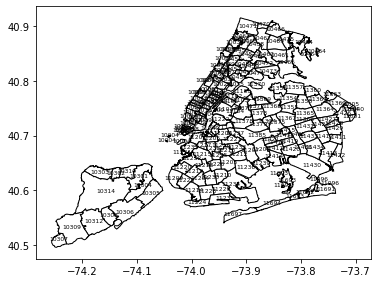

In [4]:
zip_code.geometry.plot(figsize = (6,6), color='white', edgecolor='black')
zip_code['coords'] = zip_code['geometry'].apply(lambda x: x.representative_point().coords[:])
zip_code['coords'] = [coords[0] for coords in zip_code['coords']]
for idx, row in zip_code.iterrows():
    plt.annotate(s=row['ZIPCODE'], xy=row['coords'],
                 horizontalalignment='center',size=6)

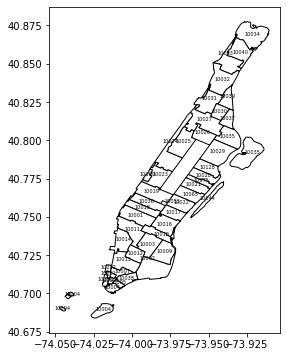

In [5]:
zip_code_district = zip_code[(zip_code.PO_NAME == 'New York')&\
                            (zip_code.POPULATION > 0)].copy()
zip_code_district.geometry.plot(figsize = (6,6), color='white', edgecolor='black')
zip_code_district['coords'] = zip_code_district['geometry'].apply(lambda x: x.representative_point().coords[:])
zip_code_district['coords'] = [coords[0] for coords in zip_code_district['coords']]
zip_code_list = []

for idx, row in zip_code_district.iterrows():
    if idx not in zip_code_list:
        plt.annotate(s=row['ZIPCODE'], xy=row['coords'],
                     horizontalalignment='center',size=5)
        zip_code_list.append(idx)

### read data and merge data

In [6]:
uber_df_list = []
for filename in os.listdir(os.getcwd()):
    if filename[-6:] == '14.csv' and filename.split('-')[0] == 'uber':
        print (filename)
        display(pd.read_csv(filename,encoding= 'unicode_escape').head(3))
        uber_df_list.append(pd.read_csv(filename))

uber-raw-data-apr14.csv


,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512


uber-raw-data-aug14.csv


,Date/Time,Lat,Lon,Base
0,8/1/2014 0:03:00,40.7366,-73.9906,B02512
1,8/1/2014 0:09:00,40.7260,-73.9918,B02512
2,8/1/2014 0:12:00,40.7209,-74.0507,B02512


uber-raw-data-sep14.csv


,Date/Time,Lat,Lon,Base
0,9/1/2014 0:01:00,40.2201,-74.0021,B02512
1,9/1/2014 0:01:00,40.7500,-74.0027,B02512
2,9/1/2014 0:03:00,40.7559,-73.9864,B02512


uber-raw-data-jul14.csv


,Date/Time,Lat,Lon,Base
0,7/1/2014 0:03:00,40.7586,-73.9706,B02512
1,7/1/2014 0:05:00,40.7605,-73.9994,B02512
2,7/1/2014 0:06:00,40.7320,-73.9999,B02512


uber-raw-data-jun14.csv


,Date/Time,Lat,Lon,Base
0,6/1/2014 0:00:00,40.7293,-73.9920,B02512
1,6/1/2014 0:01:00,40.7131,-74.0097,B02512
2,6/1/2014 0:04:00,40.3461,-74.6610,B02512


uber-raw-data-may14.csv


,Date/Time,Lat,Lon,Base
0,5/1/2014 0:02:00,40.7521,-73.9914,B02512
1,5/1/2014 0:06:00,40.6965,-73.9715,B02512
2,5/1/2014 0:15:00,40.7464,-73.9838,B02512


### data processing and geo-encoding

In [7]:
uber_df = pd.concat(uber_df_list)
#uber_df = uber_df_list[1].copy()
uber_df['Date/Time'] = pd.to_datetime(uber_df['Date/Time'], infer_datetime_format=True)  
uber_df['month'] = pd.DatetimeIndex(uber_df['Date/Time']).month
uber_df['date'] = pd.DatetimeIndex(uber_df['Date/Time']).date
uber_df['hour'] = pd.DatetimeIndex(uber_df['Date/Time']).hour 
uber_df['minute'] = pd.DatetimeIndex(uber_df['Date/Time']).minute
uber_df['Lon'] = np.round(uber_df['Lon'],4)
uber_df['Lat'] = np.round(uber_df['Lat'],4)

In [11]:
uber_df_loc_map = uber_df[['Lon','Lat']].drop_duplicates()
uber_df_geo_map = gp.GeoDataFrame(uber_df_loc_map)
uber_df_geo_map['Point'] = uber_df_geo_map.apply(lambda x:Point(x['Lon'],x['Lat']),axis=1)

In [12]:
def find_zip_code(point_data):
    for i, j in zip_code_map.iterrows():
        if point_data.within(j.geometry) :
            return j.ZIPCODE
    return np.nan

In [13]:
uber_df_geo_map['grid'] = uber_df_geo_map['Point'].apply(lambda x:find_zip_code(x) )

In [17]:
uber_df = pd.merge(uber_df,uber_df_geo_map, how='left', on=['Lon','Lat'] )

In [18]:
uber_df_geo = gp.GeoDataFrame(uber_df)

In [19]:
uber_df_geo.head(3)

,Date/Time,Lat,Lon,Base,month,date,hour,minute,Point,grid
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,4,2014-04-01,0,11,POINT (-73.95489999999999 40.769),10021
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,4,2014-04-01,0,17,POINT (-74.03449999999999 40.7267),NaN
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,4,2014-04-01,0,21,POINT (-73.9873 40.7316),10003


In [20]:
# to see the percentage of null value
len(uber_df_geo[uber_df_geo.grid.isnull()])/len(uber_df_geo)

0.05159266193196917

In [21]:
grid_ranks = uber_df_geo.groupby('grid').grid.count().sort_values(ascending = False)
grid_ranks[:5]

grid
10011    232681
10019    229276
10022    207852
10014    205258
10003    204510
Name: grid, dtype: int64

In [22]:
uber_df_geo['date'] = pd.to_datetime(uber_df_geo['date'])

/Users/frank/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


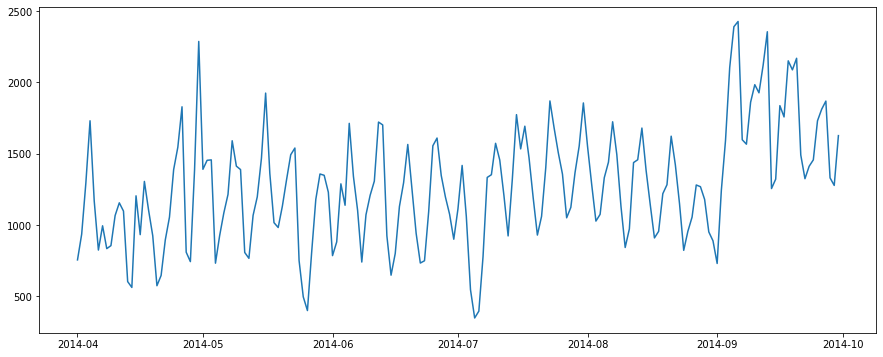

In [23]:
uber_df_geo_grid = uber_df_geo[uber_df_geo.grid == grid_ranks.index[0]]
plt.figure(figsize = (15,6))
plt.plot(uber_df_geo_grid.groupby('date').grid.count())

In [24]:
uber_df_geo.to_csv('cleaned_data_all.csv')